In [11]:
import distutils.util
import os
import subprocess
import mujoco
import time
import itertools
import numpy as np
import mediapy as media
import matplotlib.pyplot as plt
import pandas as pd
from PIL import Image

In [2]:
xml = """
<mujoco model="xarm7">
  <compiler angle="radian" autolimits="true" meshdir="assets"/>

  <option integrator="implicitfast"/>

  <asset>
    <material name="white" rgba="1 1 1 1"/>
    <material name="gray" rgba="0.753 0.753 0.753 1"/>
    <material name="black" rgba="0.149 0.149 0.149 1"/>

    <mesh file="link_base.stl"/>
    <mesh file="link1.stl"/>
    <mesh file="link2.stl"/>
    <mesh file="link3.stl"/>
    <mesh file="link4.stl"/>
    <mesh file="link5.stl"/>
    <mesh file="link6.stl"/>
    <mesh file="link7.stl"/>
    <mesh file="end_tool.stl"/>
    <mesh file="base_link.stl"/>
    <mesh file="left_outer_knuckle.stl"/>
    <mesh file="left_finger.stl"/>
    <mesh file="left_inner_knuckle.stl"/>
    <mesh file="right_outer_knuckle.stl"/>
    <mesh file="right_finger.stl"/>
    <mesh file="right_inner_knuckle.stl"/>
  </asset>

  <default>
    <default class="xarm7">
      <geom type="mesh" material="white"/>
      <joint axis="0 0 1" range="-6.28319 6.28319" frictionloss="1"/>
      <general biastype="affine" ctrlrange="-6.28319 6.28319"/>
      <default class="size1">
        <joint damping="10"/>
        <general gainprm="1500" biasprm="0 -1500 -150" forcerange="-50 50"/>
      </default>
      <default class="size2">
        <joint damping="5"/>
        <general gainprm="1000" biasprm="0 -1000 -100" forcerange="-30 30"/>
      </default>
      <default class="size3">
        <joint damping="2"/>
        <general gainprm="800" biasprm="0 -800 -80" forcerange="-20 20"/>
      </default>
      <default class="spring_link">
        <joint range="0 0.85" stiffness="0.05" springref="2.62" damping="0.00125"/>
      </default>
      <default class="driver">
        <joint range="0 0.85" armature="0.005" damping="0.1" solreflimit="0.005 1"/>
      </default>
      <default class="follower">
        <joint range="0 0.85" solreflimit="0.005 1"/>
      </default>
      <site size="0.001" rgba="1 0 0 1" group="4"/>
    </default>
  </default>

  <worldbody>
    <body name="link_base" pos="0 0 .12" childclass="xarm7">
      <inertial pos="-0.021131 -0.0016302 0.056488" quat="0.696843 0.20176 0.10388 0.680376" mass="0.88556"
        diaginertia="0.00382023 0.00335282 0.00167725"/>
      <geom mesh="link_base"/>
      <body name="link1" pos="0 0 0.267">
        <inertial pos="-0.0002 0.02905 -0.01233" quat="0.978953 -0.202769 -0.00441617 -0.0227264" mass="2.382"
          diaginertia="0.00569127 0.00533384 0.00293865"/>
        <joint name="joint1" class="size1"/>
        <geom mesh="link1"/>
        <body name="link2" quat="1 -1 0 0">
          <inertial pos="0.00022 -0.12856 0.01735" quat="0.50198 0.86483 -0.00778841 0.00483285" mass="1.869"
            diaginertia="0.00959898 0.00937717 0.00201315"/>
          <joint name="joint2" range="-2.059 2.0944" class="size1"/>
          <geom mesh="link2"/>
          <body name="link3" pos="0 -0.293 0" quat="1 1 0 0">
            <inertial pos="0.0466 -0.02463 -0.00768" quat="0.913819 0.289775 0.281481 -0.0416455" mass="1.6383"
              diaginertia="0.00351721 0.00294089 0.00195868"/>
            <joint name="joint3" class="size2"/>
            <geom mesh="link3"/>
            <body name="link4" pos="0.0525 0 0" quat="1 1 0 0">
              <inertial pos="0.07047 -0.11575 0.012" quat="0.422108 0.852026 -0.126025 0.282832" mass="1.7269"
                diaginertia="0.00657137 0.00647948 0.00186763"/>
              <joint name="joint4" range="-0.19198 3.927" class="size2"/>
              <geom mesh="link4"/>
              <body name="link5" pos="0.0775 -0.3425 0" quat="1 1 0 0">
                <inertial pos="-0.00032 0.01604 -0.026" quat="0.999311 -0.0304457 0.000577067 0.0212082" mass="1.3203"
                  diaginertia="0.00534729 0.00499076 0.0013489"/>
                <joint name="joint5" class="size2"/>
                <geom mesh="link5"/>
                <body name="link6" quat="1 1 0 0">
                  <inertial pos="0.06469 0.03278 0.02141" quat="-0.217672 0.772419 0.16258 0.574069" mass="1.325"
                    diaginertia="0.00245421 0.00221646 0.00107273"/>
                  <joint name="joint6" range="-1.69297 3.14159" class="size3"/>
                  <geom mesh="link6"/>
                  <body name="link7" pos="0.076 0.097 0" quat="1 -1 0 0">
                    <inertial pos="0 -0.00677 -0.01098" quat="0.487612 0.512088 -0.512088 0.487612" mass="0.17"
                      diaginertia="0.000132176 9.3e-05 5.85236e-05"/>
                    <joint name="joint7" class="size3"/>
                    <geom material="gray" mesh="end_tool"/>
                    <body name="xarm_gripper_base_link" quat="0 0 0 1">
                      <inertial pos="-0.00065489 -0.0018497 0.048028" quat="0.997403 -0.0717512 -0.0061836 0.000477479"
                        mass="0.54156" diaginertia="0.000471093 0.000332307 0.000254799"/>
                      <geom mesh="base_link"/>
                      <body name="left_outer_knuckle" pos="0 0.035 0.059098">
                        <inertial pos="0 0.021559 0.015181" quat="0.47789 0.87842 0 0" mass="0.033618"
                          diaginertia="1.9111e-05 1.79089e-05 1.90167e-06"/>
                        <joint name="left_driver_joint" axis="1 0 0" class="driver"/>
                        <geom material="black" mesh="left_outer_knuckle"/>
                        <body name="left_finger" pos="0 0.035465 0.042039">
                          <inertial pos="0 -0.016413 0.029258" quat="0.697634 0.115353 -0.115353 0.697634"
                            mass="0.048304" diaginertia="1.88037e-05 1.7493e-05 3.56792e-06"/>
                          <joint name="left_finger_joint" axis="-1 0 0" class="follower"/>
                          <geom material="black" mesh="left_finger"/>
                        </body>
                      </body>
                      <body name="left_inner_knuckle" pos="0 0.02 0.074098">
                        <inertial pos="1.86601e-06 0.0220468 0.0261335" quat="0.664139 -0.242732 0.242713 0.664146"
                          mass="0.0230126" diaginertia="8.34216e-06 6.0949e-06 2.75601e-06"/>
                        <joint name="left_inner_knuckle_joint" axis="1 0 0" class="spring_link"/>
                        <geom material="black" mesh="left_inner_knuckle"/>
                      </body>
                      <body name="right_outer_knuckle" pos="0 -0.035 0.059098">
                        <inertial pos="0 -0.021559 0.015181" quat="0.87842 0.47789 0 0" mass="0.033618"
                          diaginertia="1.9111e-05 1.79089e-05 1.90167e-06"/>
                        <joint name="right_driver_joint" axis="-1 0 0" class="driver"/>
                        <geom material="black" mesh="right_outer_knuckle"/>
                        <body name="right_finger" pos="0 -0.035465 0.042039">
                          <inertial pos="0 0.016413 0.029258" quat="0.697634 -0.115356 0.115356 0.697634"
                            mass="0.048304" diaginertia="1.88038e-05 1.7493e-05 3.56779e-06"/>
                          <joint name="right_finger_joint" axis="1 0 0" class="follower"/>
                          <geom material="black" mesh="right_finger"/>
                        </body>
                      </body>
                      <body name="right_inner_knuckle" pos="0 -0.02 0.074098">
                        <inertial pos="1.866e-06 -0.022047 0.026133" quat="0.66415 0.242702 -0.242721 0.664144"
                          mass="0.023013" diaginertia="8.34209e-06 6.0949e-06 2.75601e-06"/>
                        <joint name="right_inner_knuckle_joint" axis="-1 0 0" class="spring_link"/>
                        <geom material="black" mesh="right_inner_knuckle"/>
                      </body>
                      <site name="link_tcp" pos="0 0 .172"/>
                    </body>
                  </body>
                </body>
              </body>
            </body>
          </body>
        </body>
      </body>
    </body>
  </worldbody>

  <contact>
    <exclude body1="right_inner_knuckle" body2="right_outer_knuckle"/>
    <exclude body1="right_inner_knuckle" body2="right_finger"/>
    <exclude body1="left_inner_knuckle" body2="left_outer_knuckle"/>
    <exclude body1="left_inner_knuckle" body2="left_finger"/>
  </contact>

  <tendon>
    <fixed name="split">
      <joint joint="right_driver_joint" coef="0.5"/>
      <joint joint="left_driver_joint" coef="0.5"/>
    </fixed>
  </tendon>

  <equality>
    <connect anchor="0 0.015 0.015" body1="right_finger" body2="right_inner_knuckle" solref="0.005 1"/>
    <connect anchor="0 -0.015 0.015" body1="left_finger" body2="left_inner_knuckle" solref="0.005 1"/>
    <joint joint1="left_driver_joint" joint2="right_driver_joint" polycoef="0 1 0 0 0" solref="0.005 1"/>
  </equality>

  <actuator>
    <general name="act1" joint="joint1" class="size1"/>
    <general name="act2" joint="joint2" class="size1" ctrlrange="-2.059 2.0944"/>
    <general name="act3" joint="joint3" class="size2"/>
    <general name="act4" joint="joint4" class="size2" ctrlrange="-0.19198 3.927"/>
    <general name="act5" joint="joint5" class="size2"/>
    <general name="act6" joint="joint6" class="size3" ctrlrange="-1.69297 3.14159"/>
    <general name="act7" joint="joint7" class="size3"/>
    <general name="gripper" tendon="split" forcerange="-50 50" ctrlrange="0 255" biastype="affine" gainprm="0.333"
      biasprm="0 -100 -10"/>
  </actuator>

  <keyframe>
    <key name="home" qpos="0 -.247 0 .909 0 1.15644 0 0 0 0 0 0 0" ctrl="0 -.247 0 .909 0 1.15644 0 0"/>
  </keyframe>
</mujoco>


"""
model = mujoco.MjModel.from_xml_string(xml)

In [3]:
model.ngeom

15

In [4]:
model.geom_rgba

array([[0.5, 0.5, 0.5, 1. ],
       [0.5, 0.5, 0.5, 1. ],
       [0.5, 0.5, 0.5, 1. ],
       [0.5, 0.5, 0.5, 1. ],
       [0.5, 0.5, 0.5, 1. ],
       [0.5, 0.5, 0.5, 1. ],
       [0.5, 0.5, 0.5, 1. ],
       [0.5, 0.5, 0.5, 1. ],
       [0.5, 0.5, 0.5, 1. ],
       [0.5, 0.5, 0.5, 1. ],
       [0.5, 0.5, 0.5, 1. ],
       [0.5, 0.5, 0.5, 1. ],
       [0.5, 0.5, 0.5, 1. ],
       [0.5, 0.5, 0.5, 1. ],
       [0.5, 0.5, 0.5, 1. ]], dtype=float32)

""

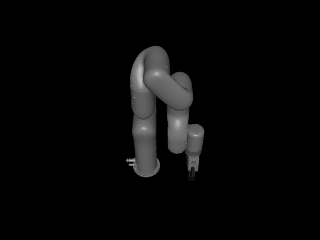

In [5]:
model = mujoco.MjModel.from_xml_string(xml)
data = mujoco.MjData(model)
renderer = mujoco.Renderer(model)

mujoco.mj_forward(model, data)
renderer.update_scene(data)

media.show_image(renderer.render())

In [16]:
def save_image(count):
    renderer = mujoco.Renderer(model)
    renderer.update_scene(data)
    # Render the image
    rendered_image = renderer.render()
    pil_image = Image.fromarray(rendered_image)
    folder_path = "images"
    if not os.path.exists(folder_path):
        os.makedirs(folder_path)
    filename = f'image{count}.png'
    image_path = os.path.join(folder_path, filename)
    pil_image.save(image_path)

In [6]:
print('Total number of DoFs in the model:', model.nv)

Total number of DoFs in the model: 13


In [7]:
mujoco.mj_kinematics(model, data)
print(data.geom_xpos)

[[-2.33092087e-03  7.63503426e-05  1.84660859e-01]
 [-1.41855430e-04  7.46384741e-03  3.59885790e-01]
 [-8.51807438e-05  4.84553684e-02  4.78245487e-01]
 [ 3.11604913e-02  2.01809082e-03  6.57433787e-01]
 [ 1.11448570e-01 -4.02904879e-02  6.03895070e-01]
 [ 1.29834481e-01 -3.17918275e-02  4.09791842e-01]
 [ 1.78996806e-01  9.04772188e-03  3.26251406e-01]
 [ 2.06000034e-01  1.43530439e-03  2.54016015e-01]
 [ 2.07367523e-01  1.80710294e-04  1.94591680e-01]
 [ 2.06000000e-01  5.23274557e-02  1.66294610e-01]
 [ 2.05985192e-01  5.49151927e-02  1.11322901e-01]
 [ 2.05971522e-01  4.09237498e-02  1.41599356e-01]
 [ 2.06000000e-01 -5.23274557e-02  1.66294610e-01]
 [ 2.05971625e-01 -5.49328460e-02  1.11354417e-01]
 [ 2.06003434e-01 -4.09219641e-02  1.41601022e-01]]


In [17]:
# Define the action spaces
act0 = np.linspace(-6.28, 6.28, 3)
act1 = np.linspace(-2.09, 2.09, 3)
act2 = np.linspace(-6.28, 6.28, 3)
act3 = np.linspace(-0.19, 3, 3)
act4 = np.linspace(-6.28, 6.28, 3)
act5 = np.linspace(-1.66, 3.49, 3)

count = 0 #variable to pass to save_image func
# Nested for loops for each action space
for i in act0:
    for j in act1:
        for k in act2:
            for l in act3:
                for m in act4:
                    for n in act5:
                        data.ctrl[0] = i
                        data.ctrl[1] = j
                        data.ctrl[2] = k
                        data.ctrl[3] = l
                        data.ctrl[4] = m
                        data.ctrl[5] = n
                        mujoco.mj_step(model, data)
                        save_image(count)
                        count += 1

KeyboardInterrupt: 